# Create Model

Using some of the findings from the `eda` section, let's try and do some modeling to check our results.

### Procedural Overview

First, we'll split our data into train / val / test sets of about 70% / 15% / 15%. Next, we'll do some preprocessing using the findings from our `eda` files, and then use `SMOTE` to deal with class imbalance. Then, we'll build out models using 5-fold cross-validation, and will tweak the threshold such that our precision (proportion of predictions that were actually true) is about 80%, and then see if this holds true with our validation set, and then our test set.

In [1]:
# Modules
import numpy as np
import pandas as pd
import os
from pathlib import Path
from xgboost import XGBClassifier
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.feature_selection import RFECV
from sklearn.metrics import classification_report
from utils import load_pickle, agg_by_count, plot_shap_summary
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold, train_test_split
import matplotlib.pyplot as plt
import shap

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


In [2]:
# Functions for Modeling

def select_features(x_train, y_train, model: str = "xgboost", metric="roc_auc"):
    if model == "xgboost":
        estimator = XGBClassifier(random_state=100, objective="binary:logistic")
    
    min_feats = 1
    kappa = metric
    rfecv = RFECV(
        estimator=estimator,
        step=1,
        cv=StratifiedKFold(n_splits=5),
        scoring=kappa,
        min_features_to_select=min_feats,
        n_jobs=-1,
        verbose=True,
    )
    rfecv.fit(x_train, y_train)
    
    print(f"Optimal number of features: {rfecv.n_features_}")
    
    # Plot number of features vs. CV scores
    plt.figure()
    plt.xlabel("Number of features selected")
    plt.ylabel(metric)
    plt.plot(range(min_feats, len(rfecv.cv_results_["mean_test_score"]) + min_feats),
             rfecv.cv_results_["mean_test_score"],
             )
    plt.show()
    
    selected_feat = x_train.columns[(rfecv.get_support())]
    
    return selected_feat
    

def model_xgboost(x_train, y_train, metric="roc_auc", tune=False):
    # Create grid
    xgb_grid = {}
    if tune is True:
        print("-----Hyperparameter Tuning for XGBoost-----")
        xgb_grid = {
            "n_estimators": [int(x) for x in np.linspace(start=100, stop=500, num=5)],
            "max_depth": [3, 5, 8, 10],
            "learning_rate": [0.01, 0.05, 0.1, 0.2, 0.3]
        }
    # Create instance of model
    estimator = XGBClassifier(objective="binary:logistic",
                              random_state=5)
    kappa = "roc_auc",
    xgb_model_tuned = RandomizedSearchCV(
        estimator=estimator,
        param_distributions=xgb_grid,
        n_iter=50,
        cv=5,
        scoring="roc_auc",
        random_state=101,
        n_jobs=-1
    )
    # Pass training into model
    xgb_model_tuned.fit(x_train, y_train)
    
    return xgb_model_tuned


# Evaluation
def evaluate(model, x, y):
    y_pred = model.predict(x)
    
    # Classification report
    print("\n",
          classification_report(y, y_pred))
    

In [3]:
# Data
raw_data = pd.read_csv(Path(os.getcwd()).parents[0].joinpath("data", "Lead Scoring.csv"))
agg_cols = load_pickle(Path(os.getcwd()).parents[0].joinpath("eda", "agg_cols.pickle"))

## Data Prep

First, we found previously in our EDA that we should aggregate certain categories. I recognize that our EDA is kind of "cheating" as its looking at the population dataset, but to save time, I'll be editting the raw data itself, then splitting into train/val/test splits.

In [4]:
# Drop specific columns
raw_data = raw_data.drop(["I agree to pay the amount through cheque",
                          "Get updates on DM Content",
                          "Update me on Supply Chain Content",
                          "Receive More Updates About Our Courses",
                          "Through Recommendations",
                          "Digital Advertisement",
                          "Newspaper",
                          "X Education Forums",
                          "Newspaper Article",
                          "Magazine",
                          "Search",
                          "What matters most to you in choosing a course",
                          "Do Not Call",
                          "A free copy of Mastering The Interview"], axis=1)

# Impute values
for key, value in agg_cols.items():
    # Impute missing values with "Missing", as following the EDA steps
    raw_data[key].fillna("Missing", inplace=True)
    
    # Then, group categories
    raw_data = agg_by_count(df=raw_data, 
                            target="Converted", 
                            group_var=key,
                            agg_list=value,
                            agg_str="minority_category")
    

### Imputation

With reference to the ProfileReport, it seems that all the numeric columns can be imputed with 0. For all categorical variables, `Missing` will be used.

In [5]:
# Impute missing values, "Missing" for categorical, 0 for numerical
cat_cols = raw_data.select_dtypes("object").columns
raw_data[cat_cols] = raw_data[cat_cols].fillna("Missing")

num_cols = raw_data.select_dtypes(np.number).columns
raw_data[num_cols] = raw_data[num_cols].fillna(0)

# Impute with 0, shuffle for randomization
data0 = raw_data.copy().sample(frac=1, random_state=5)

### One-Hot Encode Variables

Next, we need to OHE categorical variables.

## Split Data

Now, we'll split our data into train/validation/test.

In [6]:
# Create X, y
X = data0.drop(["Prospect ID", "Lead Number", "Converted"], axis=1)
y = data0["Converted"]

# One-hot encode
X = pd.get_dummies(X, drop_first=True, dtype=float)

# Check dimensions
print(f"Dimensions: {X.shape}")

# Train / validate / test
x_train, x_test, y_train, y_test = train_test_split(
    X, y, test_size=0.15, random_state=5, stratify=y
)

x_train, x_val, y_train, y_val = train_test_split(
    x_train, y_train, test_size=0.15, random_state=5, stratify=y_train
)

Dimensions: (9240, 107)


One obvious concern here is that we have a lot of columns. We'll use feature selection to minimize the number of columns present.

## SMOTE

We'll use SMOTE (synthetic minority oversampling technique) to deal with the class imblanace present in the `Converted` column.

In [7]:
# Define SMOTE pipeline
over = SMOTE(random_state=101)
under = RandomUnderSampler(random_state=101)
pipeline = Pipeline(steps=[('o', over), ('u', under)])

# Apply to dataset
x_train_s, y_train_s = pipeline.fit_resample(x_train, y_train)

# Fit to model
xgb_model_tuned = model_xgboost(x_train_s, y_train_s)

# Run evaluations
evaluate(xgb_model_tuned, x_val, y_val)


The total space of parameters 1 is smaller than n_iter=50. Running 1 iterations. For exhaustive searches, use GridSearchCV.



               precision    recall  f1-score   support

           0       0.96      0.97      0.96       725
           1       0.95      0.93      0.94       454

    accuracy                           0.95      1179
   macro avg       0.95      0.95      0.95      1179
weighted avg       0.95      0.95      0.95      1179



Our model performs shockingly well, getting a precision of 0.95 (far higher than the ask of ~80%). Initially, I expected our summary statistics to be quite low, and would then tweak the probability threshold to improve our precision (but decrease the total number of predictions labeled as "Converted").

## Feature Selection

As I alluded to previously, there are *many* variables (~98) after one-hot encoding. If given more time, I would've liked to play around with [rainbow encoding](https://towardsdatascience.com/hidden-data-science-gem-rainbow-method-for-label-encoding-dfd69f4711e1) to reduce the complexity and avoid one-hot encoding variables. However, I'll simply be using `RFECV` to perform feature selection.

Fitting estimator with 107 features.
Fitting estimator with 106 features.
Fitting estimator with 105 features.
Fitting estimator with 104 features.
Fitting estimator with 103 features.
Fitting estimator with 102 features.
Fitting estimator with 101 features.
Fitting estimator with 100 features.
Fitting estimator with 99 features.
Fitting estimator with 98 features.
Fitting estimator with 97 features.
Fitting estimator with 96 features.
Fitting estimator with 95 features.
Fitting estimator with 94 features.
Fitting estimator with 93 features.
Fitting estimator with 92 features.
Fitting estimator with 91 features.
Fitting estimator with 90 features.
Fitting estimator with 89 features.
Fitting estimator with 88 features.
Fitting estimator with 87 features.
Fitting estimator with 86 features.
Fitting estimator with 85 features.
Fitting estimator with 84 features.
Fitting estimator with 83 features.
Fitting estimator with 82 features.
Fitting estimator with 81 features.
Fitting estimator wi

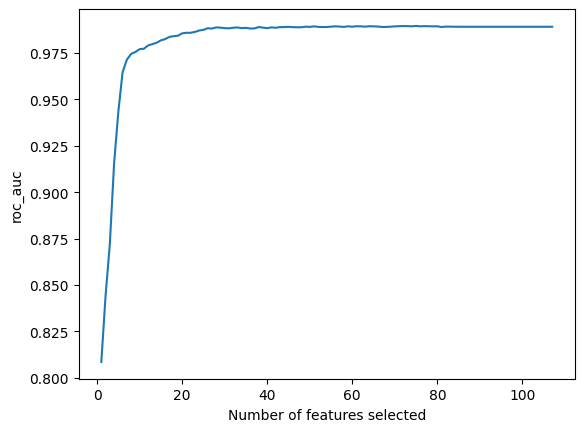

The total space of parameters 1 is smaller than n_iter=50. Running 1 iterations. For exhaustive searches, use GridSearchCV.



               precision    recall  f1-score   support

           0       0.95      0.97      0.96       725
           1       0.95      0.91      0.93       454

    accuracy                           0.95      1179
   macro avg       0.95      0.94      0.94      1179
weighted avg       0.95      0.95      0.95      1179



In [8]:
sel_feats = select_features(x_train_s, y_train_s)
x_train_sel = x_train_s[sel_feats]
y_train_sel = y_train_s

# Run model with less features
xgb_model_sel = model_xgboost(x_train_sel, y_train_sel)
evaluate(xgb_model_sel, x_val[sel_feats], y_val)

By reducing the number of features from 107 to 75, our metrics of accuracy, precision, and recall only decline slightly (~1-2% in total).

Seeing how well our model performs, apply this model to our test set.

Fitting estimator with 107 features.
Fitting estimator with 106 features.
Fitting estimator with 105 features.
Fitting estimator with 104 features.
Fitting estimator with 103 features.
Fitting estimator with 102 features.
Fitting estimator with 101 features.
Fitting estimator with 100 features.
Fitting estimator with 99 features.
Fitting estimator with 98 features.
Fitting estimator with 97 features.
Fitting estimator with 96 features.
Fitting estimator with 95 features.
Fitting estimator with 94 features.
Fitting estimator with 93 features.
Fitting estimator with 92 features.
Fitting estimator with 91 features.
Fitting estimator with 90 features.
Fitting estimator with 89 features.
Fitting estimator with 88 features.
Fitting estimator with 87 features.
Fitting estimator with 86 features.
Fitting estimator with 85 features.
Fitting estimator with 84 features.
Fitting estimator with 83 features.
Fitting estimator with 82 features.
Optimal number of features: 81


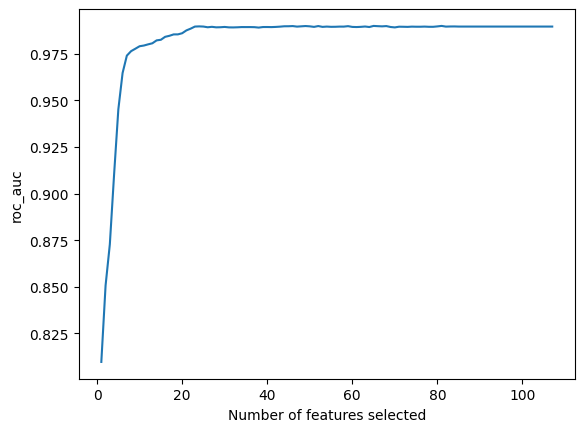

The total space of parameters 1 is smaller than n_iter=50. Running 1 iterations. For exhaustive searches, use GridSearchCV.



               precision    recall  f1-score   support

           0       0.95      0.96      0.96       852
           1       0.94      0.93      0.93       534

    accuracy                           0.95      1386
   macro avg       0.95      0.95      0.95      1386
weighted avg       0.95      0.95      0.95      1386



In [9]:
# Combine x_train, x_val and y_train, y_val
x_train2 = pd.concat([x_train, x_val]).reset_index(drop=True)
y_train2 = pd.concat([y_train, y_val]).reset_index(drop=True)

# Apply SMOTE
x_train2_s, y_train2_s = pipeline.fit_resample(x_train2, y_train2)

# Do feature selection
sel_feats2 = select_features(x_train2_s, y_train2_s)
x_train2_sel = x_train2_s[sel_feats2]
y_train2_sel = y_train2_s

# Run model with less features
xgb_model_sel2 = model_xgboost(x_train2_sel, y_train2_sel)
evaluate(xgb_model_sel2, x_test[sel_feats2], y_test)

With our test set, we see that our accuracy, precision, and recalls are all still about 95%, with the optimum number of features being 81. These values are all very good.

Again, however, there should be some concern regarding the number of variables after one-hot encoding. To better understand what are our best drivers, we'll be doing some analysis below.

# Analysis

Now that we have our model, let's see what variables are most important. Because we used a tree-based model, we'll use shap values to figure this out.

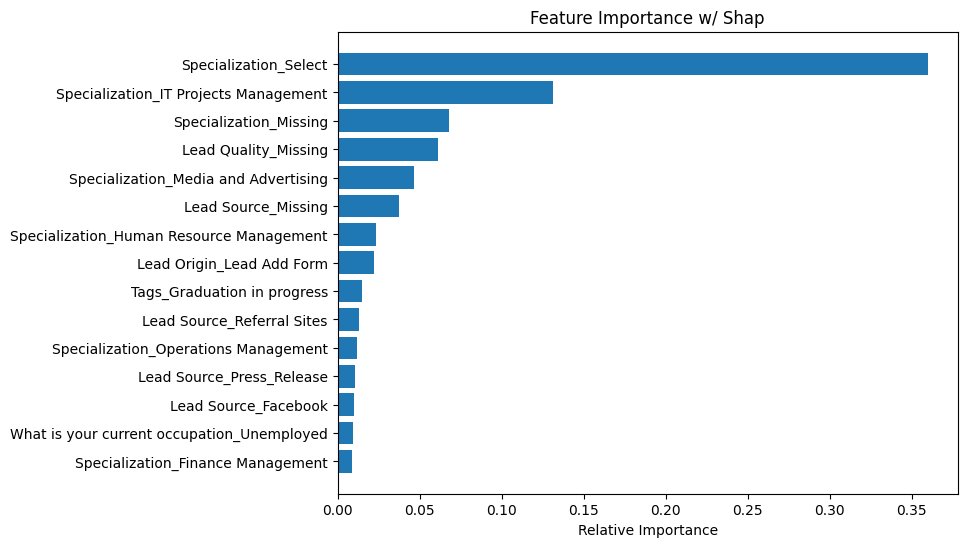

In [12]:
# Shap for all features
# Get top 15 features
features = x_train2.columns
importances = xgb_model_sel2.best_estimator_.feature_importances_
indices = np.argsort(importances)
num_features = 15

# Plotting
plt.figure(figsize=(8, 6))
plt.title("Feature Importance w/ Shap")

plt.barh(range(num_features), importances[indices[-num_features:]], align="center")
plt.yticks(range(num_features), [features[i] for i in indices[-num_features:]])
plt.xlabel("Relative Importance")
plt.show()

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


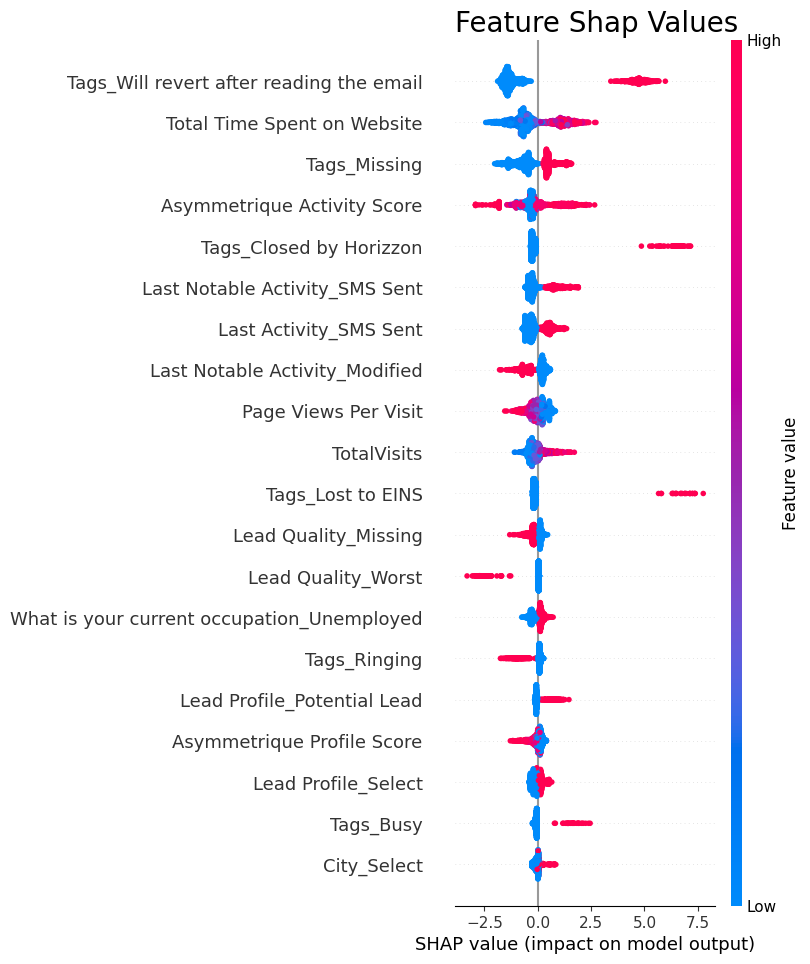

In [10]:
# Apply SHAP to entire dataset
explainer = shap.TreeExplainer(xgb_model_sel2.best_estimator_)
shap_values = explainer.shap_values(x_test[sel_feats2])

# Plot shap summary
plot_shap_summary(
    shap_values,
    x_test[sel_feats2],
    title_loc="left",
    title="Feature Shap Values",
    class_names=["Didn't Purchase", "Converted"]
)

In [ ]:
shap_values.shape

(1386, 81)